24.03.12, 24.03.14, 24.03.19 수업

24.03.26 수업

# 첫번째 실습

주택 가격을 예측하는 회귀 작업을 살펴보면서 선형 회귀, 결정 트리, 랜덤
포레스트 등 여러 알고리즘 학습

데이터 구하기 > EDA > 데이터 준비 > 선택 훈련 > 모델 파인튜닝(조정) > 솔루션 제시 > 시스템 론칭 모니터링 유지보수

In [ ]:
# Matplotlib 와 pandas 그래프에서 한글 사용 설정
import sys

## 노트북이 코랩에서 실행중인지 체크
if 'google.colab' in sys.modules:
  !echo 'debconf debconf/frontend select Noninterative' | debconf-set-selections
  ## 나눔 폰트 설치
  !sudo apt-get -qq -y install fonts-nanum
  import matplotlib.font_manager as fm
  font_files = fm.findSystemFonts(fontpaths=['/usr/share/fonts/truetype/nanum'])
  for fpath in font_files:
    fm.fontManager.addfont(fpath)

  # 나눔바른고딕 폰트 설정
  import matplotlib.pyplot as plt
  plt.rc('font', family='NanumBarunGothic')
  # 마이너스 기호 표시 오류 수정
  import matplotlib
  matplotlib.rcParams['axes.unicode_minus'] = False


debconf: unable to initialize frontend: Noninterative
debconf: (Can't locate Debconf/FrontEnd/Noninterative.pm in @INC (you may need to install the Debconf::FrontEnd::Noninterative module) (@INC contains: /etc/perl /usr/local/lib/x86_64-linux-gnu/perl/5.34.0 /usr/local/share/perl/5.34.0 /usr/lib/x86_64-linux-gnu/perl5/5.34 /usr/share/perl5 /usr/lib/x86_64-linux-gnu/perl-base /usr/lib/x86_64-linux-gnu/perl/5.34 /usr/share/perl/5.34 /usr/local/lib/site_perl) at (eval 17) line 2, <> line 1.)
debconf: falling back to frontend: Noninteractive
Selecting previously unselected package fonts-nanum.
(Reading database ... 121752 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...


In [ ]:
plt.rc('font', family='NanumBarunGothic')

In [ ]:
import warnings

# 모든 경고 무시
warnings.simplefilter("ignore")

## 0. 큰 그림

### 문제 정의
- 비지니스의 목적?
- 회사에서는 이 모델을 어떻게 사용해 이익 얻음?
- 현재 솔루션은 어떻게 구성?


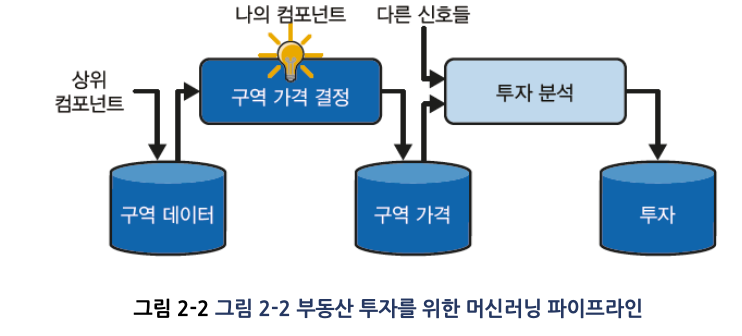


- 회사는 구역의 데이터 기반으로 중간 주택 가격을 예측하는 모델을 훈력시키는 쪽이 유용
- 정보를 취합해 시스템 설계
  - 레이블된 훈련 샘플이 있으므로 전형적인 지도학습 작업
  - 모델이 값을 예측 : 회귀문제
    - 다중회귀 : 예측에 사용할 특성이 여러개
    - 단변량 회귀 : 각 구역마다 하나의 값 예측
    - 다변량 회귀 : 구역마다 여러 개의 값을 예측
  - 시스템으로 들어오는 데이터에 연속적인 흐름이 없으므로 빠르게 변하는 데이터에 적응하지 않아도 되고 데이터가 메모리에 들어갈만큼 충분히 작으므로 일반적인 배치학습이 적절

### 성능 측정 지표 선택
- 회귀 문제의 전형적인 성능 지표는 평균 제곱근 오차(root mean square error, RMSE)
  - 오차가 커질수록 이 값은 더욱 커지므로 예측에 얼마나 많은 오차가 있는지 가늠하게 해줌
- 이상치로 보이는 구역이 많다면 평균 절대 오차(mean absolute error, MAE, 평균 절대 편차)를 고려
- RMSE와 MAE 모두 예측값의 벡터와 타깃값의 벡터 사이의 거리를 재는 방법
  - 거리 측정에는 여러 가지 방법(또는 노름(norm))을 사용
  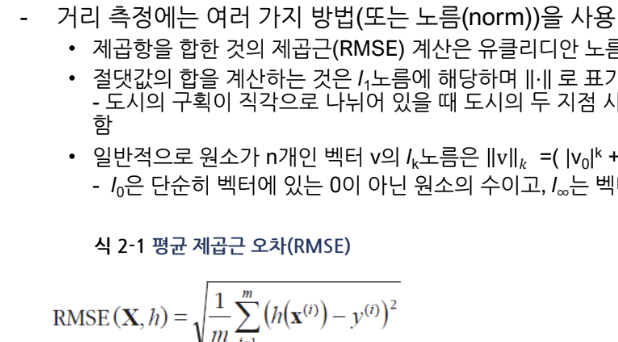
  

### 가정 검사
지금까지 만든 가정을 나열하고 검사
- 이 과정에서 심각한 문제를 일찍 발견할 수도 있음
- 예) 시스템이 출력한 구역의 가격이 그대로 다음 머신러닝 시스템의 입력으로 사용될 거라
가정했는데, 하위 시스템에서 이 값을 (‘저렴’, ‘보통’, ‘고가’ 같은) 카테고리로 바꾸고 가격 대신
카테고리를 사용하면 어떻게 될까?

  • 정확한 가격을 구하는 것이 전혀 중요하지 않고, 올바른 카테고리를 구하는 시스템이 필요
  
  • 따라서, 회귀가 아니라 분류 작업

## 1.데이터 가져오기
랜덤하게 데이터를 가져오면 할 때마다 데이터가 달라짐

In [ ]:
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request

def load_housing_data():
  tarball_path = Path('datasets/housing.tgz')
  if not tarball_path.is_file():
    Path('datasets').mkdir(parents=True, exist_ok=True)
    # 압축한 tgz 파일 내려받기 -> 내려받는 일을 자동화하면 여러 기기 데이터셋을 설치할 때도 편리
    url = 'https://github.com/ageron/data/raw/main/housing.tgz'
    urllib.request.urlretrieve(url,tarball_path)
    with tarfile.open(tarball_path) as housing_tarball:
      housing_tarball.extractall(path='datasets') # 데이터 추출
  return pd.read_csv(Path('datasets/housing/housing.csv')) ## 오류 발생 시, 새 노트를 열어서 실행

housing = load_housing_data() # 데이터 로드

In [ ]:
# 데이터 구조 훑기
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [ ]:
# 데이터 간략 설명
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


- 데이터에 대한 간략한 설명을 보여줌
- 특히 전체 행 수, 각 특성의 데이터 타입과 Null 이 아닌 값의 개수를 확인하는 데 유용
----
- total_bedrooms 특성은 널값이 다른 특성과는 좀 다름
- ocean_proximity : 문자형 데이터

In [ ]:
# 어떤 값들이 있는지 확인
housing['ocean_proximity'].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

각 카테고리마다 얼마나 많은 분류가 있는 지 확인

In [ ]:
# 숫자형 특성의 요약 정보
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


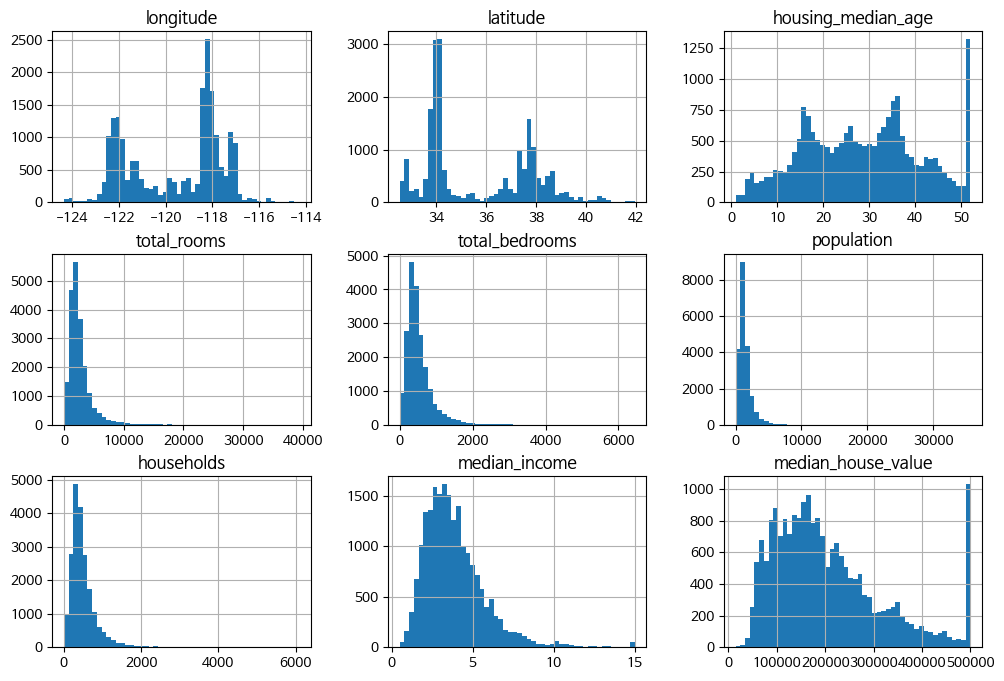

In [ ]:
import matplotlib.pyplot as plt
# 전체 데이터셋에 대해 모든 숫자형 특성에 대한 히스토그램 출력
housing.hist(bins=50, figsize=(12,8))
plt.show()

- 중간 소득 특성이 US 달러로 표현되어 있지 않음
- 중간 주택연도와 중간 주택 가격 역시 최댓값, 최솟값으로 한정
- 특성들의 스케일이 서로 많이 다름
- 많은 히스토그램에서 오른쪽 꼬리가 더 길게 나타남

### 1.1 테스트 세트 만들기

1. 데이터 스누핑 편향

In [ ]:
## 랜덤으로 어떤 샘플 선택
## 데이터셋의 20% 정도를 떼어놓음 - 데이터셋이 매우 크다면 그보다 적게!
import numpy as np

def shuffle_and_split_data(data, test_ratio):
  shuffled_indices = np.random.permutation(len(data)) # 항상 같은 난수 인덱스가 행성되도록
  test_set_size = int(len(data)*test_ratio)
  test_indices = shuffled_indices[:test_set_size]
  train_indices = shuffled_indices[test_set_size:]
  return data.iloc[train_indices], data.iloc[test_indices]

train_set, test_set = shuffle_and_split_data(housing, 0.2)

print(len(train_set), len(test_set))

16512 4128


2. crc32 분할

  - 안정적인 훈련.테스트 분할을 가능하게 함

In [ ]:
from zlib import crc32
# 주어진 식별자가 테스트 세트에 속하는지 여부 결정
def is_id_in_test_set(identifier, test_ratio):
  return crc32(np.int64(identifier)) < test_ratio*2**32 # 식별자를 해시하여 테스트 비율의 임계값 비교 -> 속하면 T, 속하지 않으면 F
# 식별자 기반으로 안정적으로 세트 분할
def split_data_with_id_hash(data, test_ratio,id_column):
  ids = data[id_column]
  in_test_set = ids.apply(lambda id_: is_id_in_test_set(id_, test_ratio))
  return data.loc[~in_test_set], data.loc[in_test_set]

In [ ]:
housing_with_id = housing.reset_index() # 인덱스 열이 추가된 데이터 프레임 반환
# 샘플의 식별자 이용해 테스트 세트 보낼지 말지 결정
train_set, test_set = split_data_with_id_hash(housing_with_id, 0.2,'index')

In [ ]:
housing_with_id['id'] = housing['longitude']*1000 + housing['latitude']
train_set, test_set = split_data_with_id_hash(housing_with_id,0.2,'id')

3. train_test_split 함수

In [ ]:
from sklearn.model_selection import train_test_split
# 행의 개수가 같은 여러개의 데이터셋을 넘겨 동일한 인덱스 기반 나누기
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42) # random_state 난수 초깃값 지정->항상 같은 난수 인수가 생성되도록

4. 계층적 샘플링

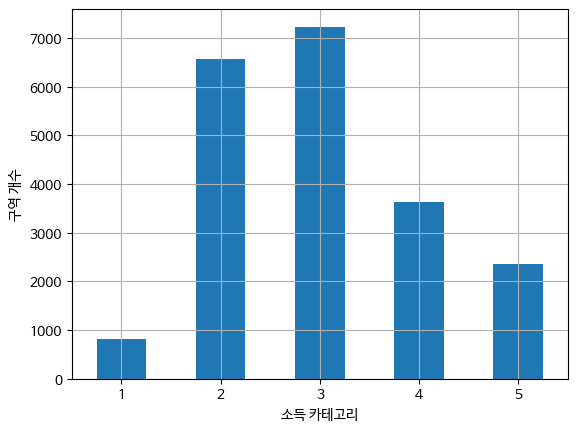

In [ ]:
housing['income_cat'] = pd.cut(housing['median_income'],
                               bins=[0.,1.5,3.0,4.5,6., np.inf], # 카테고리 다섯개 가진 소득
                               labels=[1,2,3,4,5])

housing['income_cat'].value_counts().sort_index().plot.bar(rot=0, grid=True)
plt.xlabel('소득 카테고리')
plt.ylabel('구역 개수')
plt.show()

5. sklearn.model_selection

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit
# 여러가지 분할기 클래스
## split 메서드
### 훈련과 데이터 분할에 대한 반복자 반환
### 훈련과 테스트 데이터 자체가 아니라 인덱스 반환
splitter = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
strat_splits = []
for train_index, test_index in splitter.split(housing,housing['income_cat']):
  strat_train_set_n = housing.iloc[train_index]
  strat_test_set_n = housing.iloc[test_index]
  strat_splits.append([strat_train_set_n,strat_test_set_n])

In [ ]:
# 첫번째 분할
strat_train_set, strat_test_set = strat_splits[0]

In [ ]:
from sklearn.model_selection import train_test_split
# 하나의 분할이 필요한 경우 train_test_split(), stratify 매개변수 사용
strat_train_set, strat_test_set = train_test_split(
    housing, test_size=0.2, stratify=housing['income_cat'], random_state=42
    )

In [ ]:
# 테스트 세트의 소득 카테고리 비율
strat_test_set['income_cat'].value_counts()/len(strat_test_set)

income_cat
3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: count, dtype: float64

- 계층 샘플링을 사용해 만든 테스트 세트는 전체 데이터셋에 있는 소득 카테고리의 비율과 거의 동일
- 반면 일반 랜덤 샘플링으로 만든 테스트 세트는 비율이 많이 달라짐

----
0. 원래대로 되돌리기!!!!!
- 판다스 데이터프레임의 drop 메서드는 행 또는 열을 삭제
- axis 매개변수의 기본값이 0일 때는 행을 삭제하고 1일 때는 열을 삭제
- 기본값이 False인 inplace 매개변수를 True로 설정하면 호출된 객체에 새로운 데이터프레임을
재할당하고 아무런 값도 반환하지 않음

In [ ]:
# 열을 삭제하고 원래 상태로 되돌림
for set_ in (strat_train_set, strat_test_set):
  set_.drop('income_cat', axis=1, inplace=True)

## 2. 데이터 이해를 위한 탐색과 시각화
- EDA
- 시각화

---
- train set 에 대해서만 탐색
  - 매우 크다면 탐색 단계에서 조작을 간단하고 빠르게 하기 위해 EDA를 위한 set을 별도로 샘플링
  - 학습 예제에서는"" train set의 크기가 작아 전체를 사용

In [ ]:
housing = strat_train_set.copy() # 원본에 대한 안전장치

### 2.1 지리적 데이터 시각화

1. 모든 구역을 산점도로 만들어 데이터 시각화
  - 데이터셋에는 지리정보(위도, 경도)가 포함

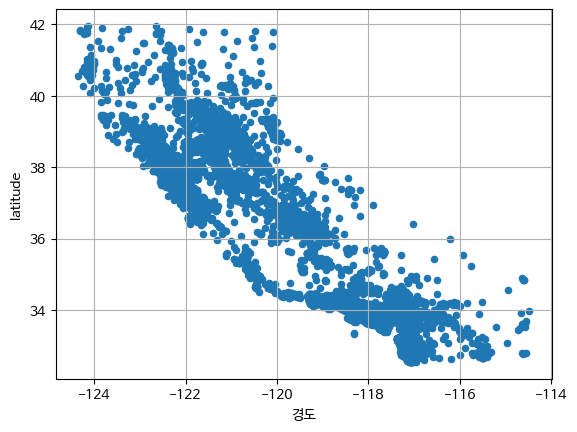

In [ ]:
# 데이터 셋에 지리 정보 포함
housing.plot(kind='scatter', x='longitude', y='latitude', grid=True)
plt.xlabel('경도')
plt.xlabel('경도')
plt.show()

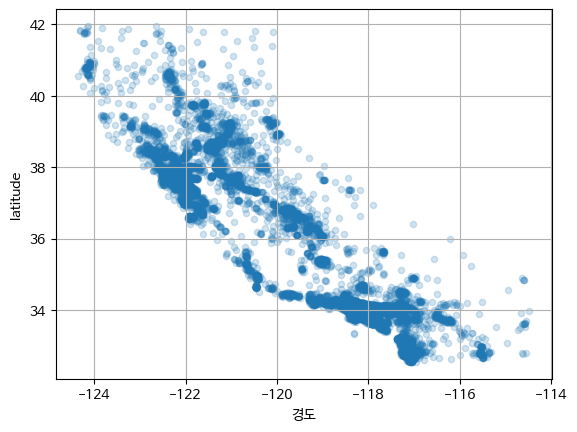

In [ ]:
# 알파가 추가된 형태 -> 데이터 포인트가 밀집된 영역 강조
## 0에 가까울 수록 투명하고 1에 가까울수록 진해짐
housing.plot(kind='scatter', x='longitude', y='latitude', grid=True, alpha=0.2)
plt.xlabel('경도')
plt.xlabel('경도')
plt.show()

2. 주택 가격 시각화
  - 원의 반지름은 구역의 인구, 색상은 가격
  - 컬러 맵 ; 파란색에서 빨간색까지의 범위를 갖는 jet 사용

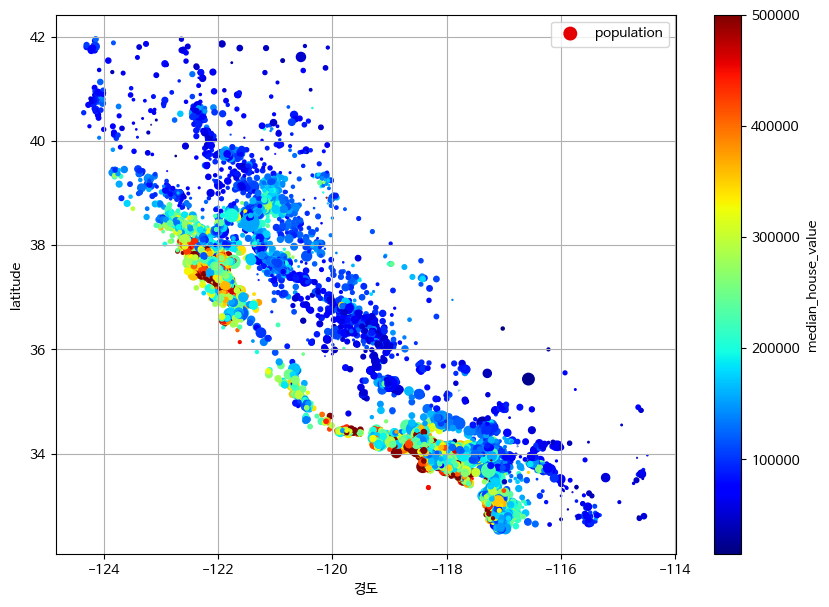

In [ ]:
# s: 마커의 사이즈, c: 마커의 컬러
# cmap : 높은 값은 빨간색, 낮은 값은 파란색
# colorbar : 좌측의 그라데이션을 둘지 말지
housing.plot(kind='scatter', x='longitude', y='latitude', grid=True,
             s=housing['population']/100, label='population',
             c='median_house_value', cmap='jet', colorbar=True,
             legend=True, sharex=False, figsize=(10,7)
             )
plt.xlabel('경도')
plt.xlabel('경도')
plt.show()

### 2.2 상관계수 조사

1. corr 매서드

In [ ]:
# 특성 간의 표준 상관계수 standard correlation coefficient (Pearson’s r)를 계산
corr_matrix = housing.corr(numeric_only=True)

In [ ]:
# 중간 주택 가격과 다른 특성 사이의 상관관계 크기
corr_matrix['median_house_value'].sort_values(ascending=False)

## 맨 위에 있는 값은 자기 자신이기 때문에 의미가 없음
## 그 다음의 변수가 가장 높은 상관관계를 갖고 있음 -> 의미있음

median_house_value    1.000000
median_income         0.688380
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
population           -0.020153
longitude            -0.050859
latitude             -0.139584
Name: median_house_value, dtype: float64

2. scatter_matrix 함수
- 특성 사이의 상관관계를 확인하기 위해 숫자형 특성 간 산점도 시각화
- 숫자형 특성이 11개이므로 11^2=121개의 그래프가 그려져야 하나, 타겟값과 상관관계가 높아 보이는 특성 몇개만 그려지게 됨

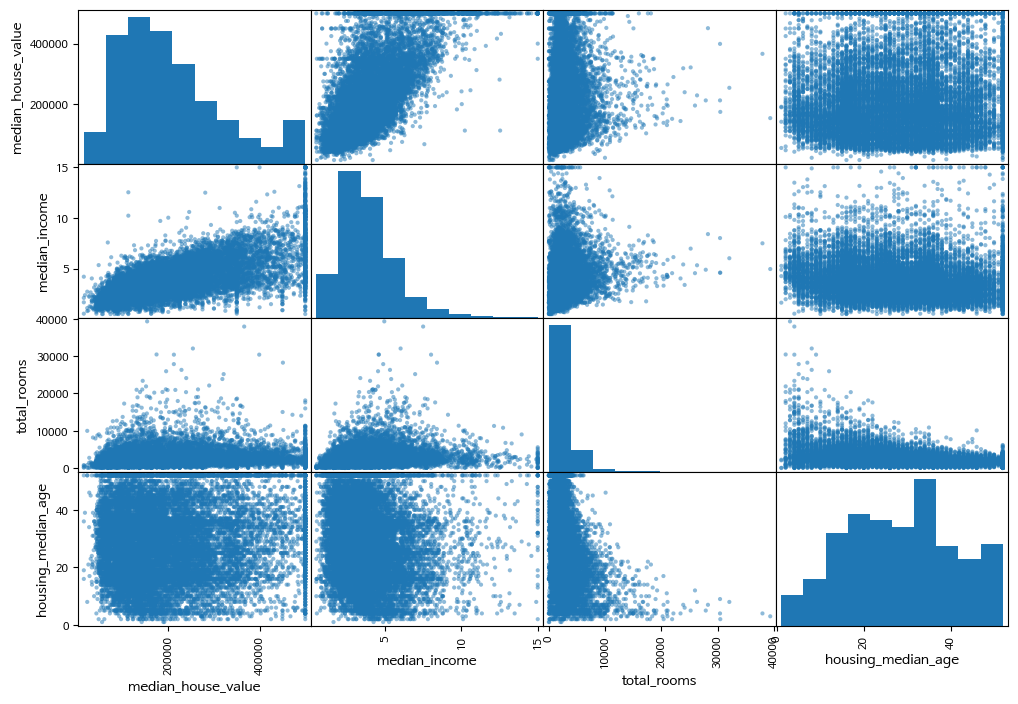

In [ ]:
from pandas.plotting import scatter_matrix

attributes = ['median_house_value','median_income','total_rooms','housing_median_age']
scatter_matrix(housing[attributes], figsize=(12,8))
plt.show()

3. 산점도

- 중간 소득으로 중간 주택가격을 예측하고 산점도 확대
  - 상관관계 매우 강함
  - 주택가격의 한계값이 500,000달라에서 수평선으로 보임

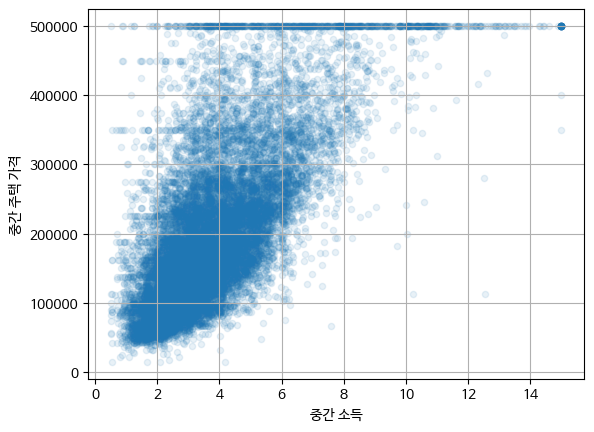

In [ ]:
# 45만, 35만에서도 수평선이 보이는데, 실제값보다는 전처리가 되어있어서 유사형태가 나타나는 것으로 보임?
housing.plot(kind='scatter', x='median_income', y='median_house_value',
             alpha=0.1, grid=True)
plt.xlabel('중간 소득')
plt.ylabel('중간 주택 가격')
plt.show()

- 상관계수는 선형적인 상관관계만 측정 : x가 증가하면 y는 증가 또는 감소
  - 비선형적인 관계는 잡을 수 없음
    - ex. x가 0에 가까워지면 y가 증가하는 경우
  
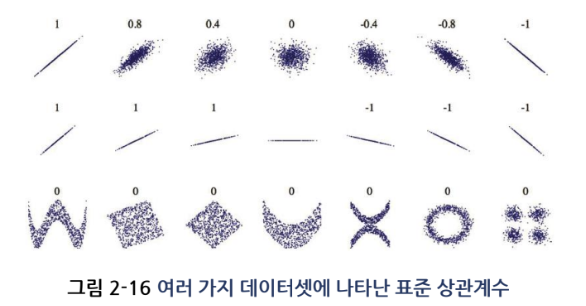

- 마지막 줄에 있는 그래프들은 두 축이 완전히 독립적이지 않음에도 상관계수가 0인 비선형 관계
- 두번째 줄은 상관계수가 1 or -1
- 상관계수는 기울기와 관계없음

### 2.3 특성조합으로 실험
- 특성을 여러가지로 조합하고 상관관계 확인

In [ ]:
housing['rooms_per_house'] = housing['total_rooms']/housing['households']  # 가구당 집 수
housing['bedrooms_ratio'] = housing['total_bedrooms']/housing['total_rooms'] # 전체 방 개수 대비 화장실 개수
housing['population_per_house'] = housing['population']/housing['households'] # 가구 대비 사람 수

In [ ]:
# 음의 상관관계가 더 생김(?)
## 인구 자체 변수 말고 가구 당 인구수로 보는 게 더 작합하다는 것은 자명
corr_matrix=housing.corr(numeric_only=True)
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value      1.000000
median_income           0.688380
rooms_per_house         0.143663
total_rooms             0.137455
housing_median_age      0.102175
households              0.071426
total_bedrooms          0.054635
population             -0.020153
population_per_house   -0.038224
longitude              -0.050859
latitude               -0.139584
bedrooms_ratio         -0.256397
Name: median_house_value, dtype: float64

## 3. ML 을 위한 데이터 준비

데이터 자동화의 장점
- 어떤 데이터 셋에 대해서도 데이터 변환을 손쉽게 반복
- 향후 프로젝트에 재사용 가능한 변환 라이브러리 점진적으로 구축
- 실제 시스템에서 알고리즘에 새 데이터를 주입하기 전에 이 함수를 사용해 변환
- 여러 가지 데이터 변환을 쉽게 시도해볼 수 있고 어떤 조합이 가장 좋은지 확인

In [ ]:
# 원래 훈련세트로 복원(strat_train_set 다시 복사)
housing = strat_train_set.drop("median_house_value",axis=1) # 예측변수와 타깃값에 같은 변형을 적용하지 않기 위해 예측 변수와 레이블 분리
## drop은 기본적으로 데이터 복사본을 만들어 반환하며 strat_train_set에 영향을 주지 않음
housing_labels = strat_train_set['median_house_value'].copy()

### 3.1 데이터 정제

1. 결측치 처리 numpy
  - 머신러닝 알고리즘은 누락된 특성을 다루지 못하기 때문에 이를 처리할 수 있는 함수를 몇개 생성

In [ ]:
# 결측치 처리 방법 -> 셋 중 하나 실행해보기
'''
## 1) 해당 구역 제거
housing.dropna(subset=['total_bedrooms'], inplace=True)
## 2) 전체 특성 삭제
housing.drop('total_bedrooms', inplace=True)'''
## 3) 누락된 값을 어떤 값으로 채우기 - 이름 대체
median = housing['total_bedrooms'].median()
housing['total_bedrooms'].fillna(median, inplace=True)

2. SimpleImputer
  - 각 특성의 중간값을 저장하고 있어 유용
  - 훈련 세트뿐만 아니라 검증 세트와 테스트 세트 그리고 모델에 주입될 새로운 데이터에 있는 누락된 값을 대체

In [ ]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='median')
imputer

SimpleImputer(strategy='median')

In [ ]:
# 중간값은 수치형 특성에서만 계산될 수 있기 때문에 수치 특성만 가진 데이터 복사본 생성
## 수치 특성만 가진 데이터 복사본 생성
housing_num = housing.select_dtypes(include=[np.number])
## 훈련 데이터에 적용
imputer.fit(housing_num)

SimpleImputer(strategy='median')

In [ ]:
# imputer는 각 특성의 중간값을 계산해서 그 결과를 객체의 statistics_ 속성에 저장
print(imputer.statistics_)
print(housing_num.median().values)

[-118.51     34.26     29.     2125.      434.     1167.      408.
    3.5385]
[-118.51     34.26     29.     2125.      434.     1167.      408.
    3.5385]


In [ ]:
# imputer 객체를 사용해 훈련세트에서 누란된 값을 학습한 중간값으로 변경
## 누락된 평균이나 가장 자주 등장하는 값 또는 상수로 변경할 수 있음 -> 자주등장, 상수 대체는 수치가 아닌 데이터 지원
X = imputer.transform(housing_num)

imputer.transform(housing_num)의 출력은 넘파이 배열

In [ ]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns, # housing_num으로부터 열이름과 인덱스 복원
                          index=housing_num.index)

**사이킷런의 철학**
- 일관성: 모든 객체는 일관되고 단순한 인터페이스를 공유
  - 추정기(estimator) : 데이터셋을 기반으로 일련의 모델 파라미터들을 추정하는 객체
  - 변환기(transformer) : (imputer 같이) 데이터셋을 변환하는 추정기
  - 예측기(predictor) : 주어진 데이터셋에 대해 예측을 만드는 추정기
- 검사 가능
- 클래스 남용 방지
- 조합성: 기존의 구성 요소를 최대한 재사용
- 합리적인 기본값

### 3.2 텍스트와 범주형 특성 다루기

In [ ]:
housing_cat = housing[['ocean_proximity']]
housing_cat.head(8) # 범주형 데이터인 것을 확인했으니까 변환하는 과정 필요

,ocean_proximity
13096,NEAR BAY
14973,<1H OCEAN
3785,INLAND
14689,INLAND
20507,NEAR OCEAN
1286,INLAND
18078,<1H OCEAN
4396,NEAR BAY


1. Ordinal Encoder

In [ ]:
# Ordinal Encoder
from sklearn.preprocessing import OrdinalEncoder # 카테고리를 텍스트에서 숫자로 변환

# 카테고리 값이 어떤게 있는지 찾아보고 매핑
ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
## housing_cat_encoded에 인코딩된 몇 개의 값을 확인 : transform 값 자체를 변경 ㄱ
housing_cat_encoded[:8]

array([[3.],
       [0.],
       [1.],
       [1.],
       [4.],
       [1.],
       [0.],
       [3.]])

In [ ]:
# categories_ 인스턴스 변수
ordinal_encoder.categories_
## 결과를 인코딩하면 배열을 순서대로 번호대로! 인코딩
## 단점이 있을때는 카테고리별 이진 특성을 만들어 해결

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

- 머신러닝 알고리즘이 가까이 있는 두 값을 떨어져 있는 두 값보다 더 비슷하다고 생각
  - 일부 경우에는 괜찮음(예: 'bad', 'average', 'good’, 'excellent'와 같이 순서가 있는 카테고리의 경우)
  - ocean_proximity 열에는 해당되지 않음
  (예를 들어 카테고리 0과 1보다 카테고리 0과 4가 확실히 더 비슷)

- 일반적으로 카테고리별 이진 특성을 만들어 해결
  - 카테고리가 '<1H OCEAN'일 때 한 특성이 1이고(그 외 특성은 0), 카테고리가 'INLAND'일 때
다른 한 특성이 1이 되는(역시 그 외에는 0) 방식

- 원-핫 인코딩(one-hot encoding)
  - 한 특성만 1이고(핫) 나머지는 0

- 더미(dummy) 특성

2. OneHotEncoder

In [ ]:
# OneHotEncoder 클래스
from sklearn.preprocessing import OneHotEncoder

# 의미없이 적지 않고 어떤 변수를 담는지 명확하게 표현
cat_encoder = OneHotEncoder() # OneHotEncoder를 만들 때 sparse=False(또는 sparse_output=False)로 설정하여 transform()메서드가 일반적인 넘파이 배열을 반환하게 할 수 있음
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot ## 사이파이에서는 효율적으로 저장할 수 있도록 사이파이 희소행렬

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [ ]:
# 희소행렬을 넘파이 배열로 반환-> 희소행렬은 0이 대부분인 행렬을 매우 효율적으로 표현, 내부적으로 0이 아닌 값과 그 위치만 저장
housing_cat_1hot.toarray()

array([[0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.]])

In [ ]:
# OrdinalEncoder처럼 인코더의 categories_ 인스턴스 변수를 사용
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

3. get_dummies()함수

In [ ]:
# get_dummies
df_test = pd.DataFrame({'ocean_proximity':['INLAND','NEAR BAY']}) # 카테고리마다 하나씩 이진생성 -> 판다스
pd.get_dummies(df_test)

,ocean_proximity_INLAND,ocean_proximity_NEAR BAY
0,True,False
1,False,True


In [ ]:
cat_encoder.transform(df_test).toarray()

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [ ]:
# <2H OCEAN => housing_cat에 있던 말던 결과는 만들어진다
df_test_unknown = pd.DataFrame({'ocean_proximity':['<2H OCEAN','ISLAND']})
pd.get_dummies(df_test_unknown)

,ocean_proximity_<2H OCEAN,ocean_proximity_ISLAND
0,True,False
1,False,True


In [ ]:
cat_encoder.handle_unknown = 'ignore'
cat_encoder.transform(df_test_unknown).toarray()

array([[0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.]])

In [ ]:
print(cat_encoder.feature_names_in_)
print(cat_encoder.get_feature_names_out())

['ocean_proximity']
['ocean_proximity_<1H OCEAN' 'ocean_proximity_INLAND'
 'ocean_proximity_ISLAND' 'ocean_proximity_NEAR BAY'
 'ocean_proximity_NEAR OCEAN']


사이킷런은 transform()이나 predict()를 통해 이 추정기에 입력된 모든 데이터프레임이 동일한 열 이름을 갖는지 확인

In [ ]:
df_output = pd.DataFrame(cat_encoder.transform(df_test_unknown).toarray(),
                         columns=cat_encoder.get_feature_names_out(),
                         index=df_test_unknown.index
                         )
df_output

,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0


### 3.3 특성 스케일과 변환

모든 특성의 범위를 갖게 하기

In [ ]:
# min-max 스케일링 – 정규화(normalization)
from sklearn.preprocessing import MinMaxScaler # MinMaxScaler 변환기 사용
min_max_scaler = MinMaxScaler(feature_range=(-1,1)) # feature_range 매개변수 사용
housing_num_min_max_scaled = min_max_scaler.fit_transform(housing_num)

In [ ]:
# 표준화
from sklearn.preprocessing import StandardScaler
std_scaler = StandardScaler()
housing_num_std_scaled = std_scaler.fit_transform(housing_num)

- 멱법칙
  - 분포가 균등하게 있을 수 있도록 로그 변환
  - 특성 분포의 꼬리가 아주 길고 두껍다면 특성을 로그값으로 바꾸는 것이 도움
- 버킷타이징
  - 값 자체를 버킷의 아이디로 변환
  - 거의 동일한 크기의 버킷을 사용하면 거의 균등 분포인 특성을 만들 수 있음
- 멀티모달 분포 변환
  - 버킷 인덱스를 인코딩
  - 중간 주택 년도와 특정 모드 사이의 유사도를 나타내는 특성 추가
    - 유사도 측정은 일반적으로 입력값과 고정 포인트 사이의 거리에만 의존하는 방사기저함수(RBF)사용

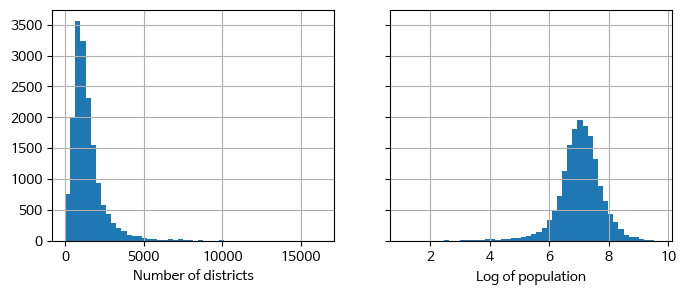

In [ ]:
# 멱법칙 분포
fig, axs = plt.subplots(1,2,figsize=(8,3),
                        sharey=True)
housing['population'].hist(ax=axs[0], bins=50)
housing['population'].apply(np.log).hist(ax=axs[1],bins=50)
axs[0].set_xlabel('Population')
axs[1].set_xlabel('Log of population')
axs[0].set_xlabel('Number of districts')
plt.show()

In [ ]:
# 방사 기저 함수 (RBF)
from sklearn.metrics.pairwise import rbf_kernel

age_simil_35 = rbf_kernel(housing[['housing_median_age']],
                          [[35]], # 고정포인트
                          gamma=0.1) # 분포가 달라짐,
                          ## 값이 클수록 분포가 급감. 작을수록 천천히 감소

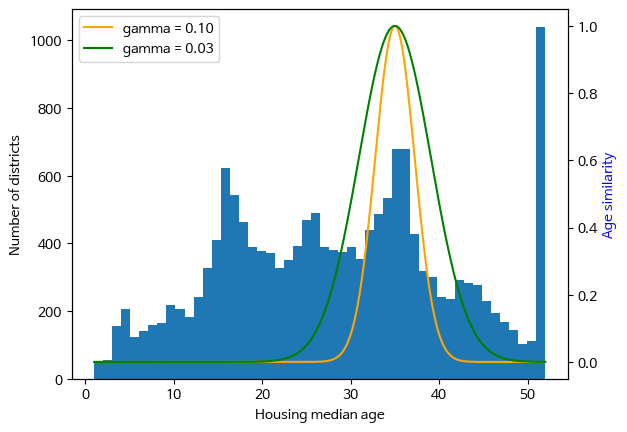

In [ ]:
ages = np.linspace(housing["housing_median_age"].min(),
                   housing["housing_median_age"].max(),
                   500).reshape(-1, 1)
gamma1 = 0.1
gamma2 = 0.03
rbf1 = rbf_kernel(ages, [[35]], gamma=gamma1)
rbf2 = rbf_kernel(ages, [[35]], gamma=gamma2)

fig, ax1 = plt.subplots()

ax1.set_xlabel("Housing median age")
ax1.set_ylabel("Number of districts")
ax1.hist(housing["housing_median_age"], bins=50)

ax2 = ax1.twinx() # x축을 공유 하는 쌍둥이 축을 만듭니다

ax2.plot(ages, rbf1, color='orange', label="gamma = 0.10")
ax2.plot(ages, rbf2, color='green', label="gamma = 0.03")
ax2.tick_params(axis='y')
ax2.set_ylabel("Age similarity", color='blue')

plt.legend(loc="upper left")
plt.show()

- 가장 널리 사용되는 RBF는 입력값이 고정 포인트에서 멀어질수록 출력값이 지수적으로 감소하는 RBF
- rbf_kernel()함수를 사용해 중간주택연도와 35 사이의 유사도를 재는 새로운 가우스 RBF 특성 생성

In [ ]:
# 역변환을 수행하는 메서드
from sklearn.linear_model import LinearRegression
target_scaler = StandardScaler()
scaled_labels = target_scaler.fit_transform(housing_labels.to_frame())
model = LinearRegression()
model.fit(housing[['median_income']],scaled_labels)
some_new_data = housing[['median_income']].iloc[:5] # 새로운 데이터라 가정
scaled_predictions = model.predict(some_new_data)
predictions = target_scaler.inverse_transform(scaled_predictions) # 역변환 적용

In [ ]:
predictions

array([[131997.15275877],
       [299359.35844434],
       [146023.37185694],
       [138840.33653057],
       [192016.61557639]])

In [ ]:
# 원래의 스케일로 되돌리기
from sklearn.compose import TransformedTargetRegressor

model = TransformedTargetRegressor(LinearRegression(),
                                   transformer=StandardScaler())
model.fit(housing[['median_income']], housing_labels)
predictions = model.predict(some_new_data)

In [ ]:
predictions

array([131997.15275877, 299359.35844434, 146023.37185694, 138840.33653057,
       192016.61557639])

### 3.4 사용자 정의 변환기

In [ ]:
# 로그 변환기를 만들어 특성에 적용
from sklearn.preprocessing import FunctionTransformer

log_transformer = FunctionTransformer(np.log, inverse_func=np.exp)
log_pop = log_transformer.transform(housing[['population']])

In [ ]:
# 가우스 RBF 유사도를 계산하는 변환기 생성
rbf_transformer = FunctionTransformer(rbf_kernel,
                                      kw_args=dict(Y=[[35.]], gamma=0.1)) ## keyword_argument : y라는 이름으로 유사도 기준 설정
age_smil_35 = rbf_transformer.transform(housing[['housing_median_age']])

In [ ]:
# 각 구역과 샌프란시스코 사이의 지리적 유사도 측정하는 특성 추가
sf_coords = 37.7749, -122.41 # 두개의 값으로 위도와 경도 측정
sf_transformer = FunctionTransformer(rbf_kernel,
                                      kw_args=dict(Y=[sf_coords], gamma=0.1))
sf_simil = sf_transformer.transform(housing[["latitude", "longitude"]])

In [ ]:
# 사용자 정의 변환기로 특성 합치기
## 첫번째 입력 특성과 두번째 특성 사이의 비율을 계산하는 FunctionTransformer
ratio_transformer = FunctionTransformer(lambda X: X[:, [0]]/X[:,[1]])
ratio_transformer.transform(np.array([[1.,2.], [3.,4.]]))

array([[0.5 ],
       [0.75]])

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin # 두가지 클래스 상속
from sklearn.utils.validation import check_array, check_is_fitted

class StandardScalerClone(BaseEstimator,TransformerMixin):
    def __init__(self,with_mean=True):
      self.with_mean = with_mean

    def fit(self, X, y=None): # 사용하지 않더라도 y를 넣어야 함
      X = check_array(X) # X가 부동소수점 배열인지 확인
      self.mean_ = X.mean(axis=0)
      self.scale_ = X.std(axis=0)
      self.n_features_in_ = X.shape[1] # 모든 추정기는 fit에서 이를 저장
      return self # 항상 반환

    def transform(self, X):
      check_is_fitted(self) # 훈련으로 학습된 속성이 있는지 확인
      X = check_array(X)
      assert self.n_features_in_ == X.shape[1]
      if self.with_mean:
          X = X - self.mean_
      return X / self.scale_

군집 알고리즘
- 대표적인 비지도학습의 알고리즘

In [ ]:
# 하나의 사용자 변환기가 구현 안에서 다른 추정기 사용
from sklearn.cluster import KMeans

class ClusterSimilarity(BaseEstimator, TransformerMixin):
  def __init__(self,n_clusters=10, gamma=1.0, random_state=None):
      self.n_clusters = n_clusters
      self.gamma = gamma
      self.random_state = random_state

  def fit(self, X, y=None, sample_weight=None):
    self.kmeans_ = KMeans(self.n_clusters, random_state=self.random_state)
    self.kmeans_.fit(X, sample_weight=sample_weight) # 훈련데이터에 있는 핵심 클러스터를 식별하기 위해 KMeans 클래스를 사용하는 사용자 변환기
    return self # 항상 self 반환

  def transform(self, X):
    return rbf_kernel(X, self.kmeans_.cluster_centers_, gamma=self.gamma) # 각 샘플이 클러스터 중심과 얼마나 유사한지 측정

  def get_feature_names_out(self, names=None):
    return [f"클러스터 {i} 유사도" for i in range(self.n_clusters)]

In [ ]:
# k-means는 데이터에 있는 클러스터를 찾는 군집 알고리즘
cluster_simil = ClusterSimilarity(n_clusters=10, gamma=1, random_state=42)
similarities = cluster_simil.fit_transform(housing[['latitude', 'longitude']],
                                           sample_weight=housing_labels) # 해당 매개변수에 샘플의 상대적인 가중치 지정
similarities[:3].round(2) # Kmeans로 클러스터 찾고 각 구역과 10개의 클러스터 중심 사이의 가우스 RBF 유사도 측정

array([[0.  , 0.14, 0.  , 0.  , 0.  , 0.08, 0.  , 0.99, 0.  , 0.6 ],
       [0.63, 0.  , 0.99, 0.  , 0.  , 0.  , 0.04, 0.  , 0.11, 0.  ],
       [0.  , 0.29, 0.  , 0.  , 0.01, 0.44, 0.  , 0.7 , 0.  , 0.3 ]])

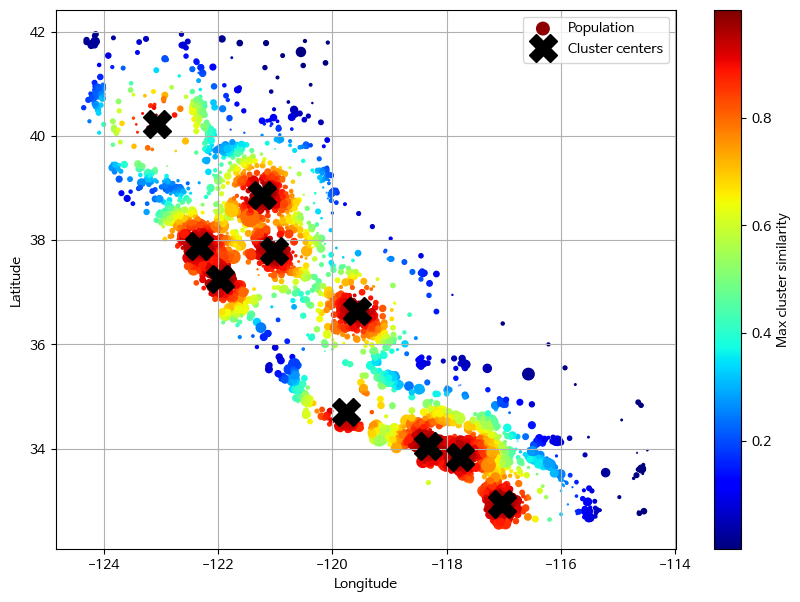

In [ ]:
# kmeans 로 찾은 클러스터 10개의 중심
housing_renamed = housing.rename(columns={"latitude": "Latitude", "longitude": "Longitude",
                                          "population": "Population",
                                          "median_house_value": "Median house value (ᴜsᴅ)"})
housing_renamed["Max cluster similarity"] = similarities.max(axis=1)

housing_renamed.plot(kind="scatter", x="Longitude", y="Latitude",
                    grid=True,
                    s=housing_renamed["Population"] / 100,
                    label="Population",
                    c="Max cluster similarity",
                    cmap="jet", colorbar=True,
                    legend=True, sharex=False, figsize=(10, 7))

plt.plot(cluster_simil.kmeans_.cluster_centers_[:, 1],
          cluster_simil.kmeans_.cluster_centers_[:, 0],
          linestyle="", color="black", marker="X", markersize=20,
          label="Cluster centers")
plt.legend(loc="upper right")
plt.show()

- 빨갛게 표시된 부분은 유사부분, 파란색은 멀어져있는 구역들
- 마커의 사이즈는 인구수     
  -> 동그라미가 크면 클수록 많은 사람들이 거주하는 구역

### 3.5 변환 파이프라인

지금까지 실험한 모든 변환을 수행할 단일 파이프라인 만들기
- 대부분의 머신러닝 알고리즘은 누락된 값을 기대하지 않기 때문에 수치형 특성의 경우 누락된
값을 중간값으로 대체 범주형 특성의 경우 누락된 값을 가장 많이 등장하는 카테고리로 변경
- 대부분의 머신러닝 알고리즘은 수치 입력만 받기 때문에 범주형 특성을 원-핫 인코딩
- 비율 특성인 bedrooms_ratio, rooms_per_house, people_per_house를 계산하여 추가
이런 특성은 중간 주택 가격과 상관관계가 높으므로 머신러닝 모델에 도움
- 몇 가지 클러스터 유사도 특성을 추가 위도와 경도보다 모델에 더 유용할 가능성이 높음
- 대부분의 모델은 균등 분포나 가우스 분포에 가까운 특성을 선호하므로 꼬리가 두꺼운 분포를
띠는 특성을 로그값으로 변경
- 대부분의 머신러닝 알고리즘은 모든 특성이 대체로 동일한 스케일을 가질 때 잘 작동하므로
모든 수치 특성을 표준화

In [ ]:
from sklearn.pipeline import Pipeline # 변환을 순서대로 처리하도록 도와주는 기능

num_pipeline = Pipeline([
    ('impute', SimpleImputer(strategy="median")), # 수치 특성에서 누락된 값을 대체하고 스케일을 조정하는 간단한 파이프라인 코드
    ('standardize', StandardScaler()),
    ])

In [ ]:
from sklearn.pipeline import make_pipeline # 위치 매개변수로 변환기를 받고 변환기의 클래스 이름을 밑줄문자없이 소문자로 바꿔 객체 생성

num_pipeline = make_pipeline(SimpleImputer(strategy="median"), StandardScaler())

In [ ]:
# 추정기가 변환기가 아니라 예측기라면 transform() 메서드 대신 predict() 메서드
housing_num_prepared = num_pipeline.fit_transform(housing_num)
housing_num_prepared[:2].round(2)

array([[-1.42,  1.01,  1.86,  0.31,  1.37,  0.14,  1.39, -0.94],
       [ 0.6 , -0.7 ,  0.91, -0.31, -0.44, -0.69, -0.37,  1.17]])

In [ ]:
# 데이터프레임으로 재구성하는 get_feature_names_out() 메서드
df_housing_num_prepared = pd.DataFrame(
    housing_num_prepared, columns=num_pipeline.get_feature_names_out(),
    index=housing_num.index
    )

In [ ]:
housing.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'ocean_proximity'],
      dtype='object')

범주형 특성을 위한 cat_pipeline
1. 먼저 정의 - 범주형은 최빈값
2. 원핫 인코더, 모르는 문제는 무시 - 'ignore'
3. 합쳐서 comlumntransformer에 넣어 이걸 쓸거다 - pipeline 특성 - attribs 아래도 동일

In [ ]:
from sklearn.compose import ColumnTransformer
## 하나의 변환기로 각 열마다 적절한 변환을 적용해 모든 열을 처리
## ColumnTransformer는 num_pipeline을 수치형 특성에, cat_pipeline을 범주형 특성에 적용하는 코드

num_attribs = ['longitude', 'latitude', 'housing_median_age', 'total_rooms',
                  'total_bedrooms', 'population', 'households', 'median_income']
cat_attribs = ['ocean_proximity']

cat_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore")
)

preprocessing = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", cat_pipeline, cat_attribs),
])

위에서 정의한걸 적용 - fit_transform pandas 하고 싶으면 get_features_out_names

In [ ]:
from sklearn.compose import make_column_selector, make_column_transformer
## 수치형이나 범주형처럼 주어진 타입의 모든 특성을 자동으로 선택
## 자동으로 이름을 지정하는 make_column_transformer()함수

preprocessing = make_column_transformer(
    (num_pipeline, make_column_selector(dtype_include=np.number)),
    (cat_pipeline, make_column_selector(dtype_include=object)),
)

# columntransformer를 주택 데이터셋에 적용할 준비 완료
housing_prepared = preprocessing.fit_transform(housing)
housing_prepared

array([[-1.42303652,  1.0136059 ,  1.86111875, ...,  0.        ,
         1.        ,  0.        ],
       [ 0.59639445, -0.702103  ,  0.90762971, ...,  0.        ,
         0.        ,  0.        ],
       [-1.2030985 ,  1.27611874,  0.35142777, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.25620853, -1.42870103, -1.23772062, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.58639727, -0.73960483,  0.66925745, ...,  0.        ,
         0.        ,  0.        ],
       [-1.41803793,  0.94797769,  1.22545939, ...,  0.        ,
         0.        ,  1.        ]])

지금까지 실험한 모든 변환을 수행할 단일 파이프라인 만들기
- 대부분의 머신러닝 알고리즘은 누락된 값을 기대하지 않기 때문에 수치형 특성의 경우 누락된
값을 중간값으로 대체 범주형 특성의 경우 누락된 값을 가장 많이 등장하는 카테고리로 변경
- 대부분의 머신러닝 알고리즘은 수치 입력만 받기 때문에 범주형 특성을 원-핫 인코딩
- 비율 특성인 bedrooms_ratio, rooms_per_house, people_per_house를 계산하여 추가
이런 특성은 중간 주택 가격과 상관관계가 높으므로 머신러닝 모델에 도움
- 몇 가지 클러스터 유사도 특성을 추가 위도와 경도보다 모델에 더 유용할 가능성이 높음
- 대부분의 모델은 균등 분포나 가우스 분포에 가까운 특성을 선호하므로 꼬리가 두꺼운 분포를
띠는 특성을 로그값으로 변경
- 대부분의 머신러닝 알고리즘은 모든 특성이 대체로 동일한 스케일을 가질 때 잘 작동하므로
모든 수치 특성을 표준화

In [ ]:
# 모든 작업을 수행하는 파이프라인을 만드는 코드
def column_ratio(X):
  return X[:,[0]]/X[:, [1]]

def ratio_name(function_transformer, feature_names_in):
  return ['ratio'] # get_feature_names_out 사용

def ratio_pipeline():
  return make_pipeline(
          SimpleImputer(strategy="median"),
          FunctionTransformer(column_ratio, feature_names_out=ratio_name),
          StandardScaler())

log_pipeline = make_pipeline(
                SimpleImputer(strategy="median"),
                FunctionTransformer(np.log, feature_names_out="one-to-one"),
                StandardScaler())

cluster_simil = ClusterSimilarity(n_clusters=10, gamma=1., random_state=42)
default_num_pipeline = make_pipeline(SimpleImputer(strategy="median"),
                                     StandardScaler())

preprocessing = ColumnTransformer([
                ("bedrooms", ratio_pipeline(), ["total_bedrooms", "total_rooms"]),
                ("rooms_per_house", ratio_pipeline(), ["total_rooms", "households"]),
                ("people_per_house", ratio_pipeline(), ["population", "households"]),
                ("log", log_pipeline, ["total_bedrooms", "total_rooms",
                                         'population', 'households', 'median_income']),
                ("geo", cluster_simil, ["latitude", "longitude"]),
                ("cat", cat_pipeline, make_column_selector(dtype_include=object)),
              ],
            remainder=default_num_pipeline) # 남은 특성 : housing_medain_age

In [ ]:
# 모든 변환이 수행되고 24개의 특성을 가진 넘파이 배열 출력
housing_prepared = preprocessing.fit_transform(housing) # 모든 변환 수행
housing_prepared.shape

(16512, 24)

In [ ]:
preprocessing.get_feature_names_out()

array(['bedrooms__ratio', 'rooms_per_house__ratio',
       'people_per_house__ratio', 'log__total_bedrooms',
       'log__total_rooms', 'log__population', 'log__households',
       'log__median_income', 'geo__클러스터 0 유사도', 'geo__클러스터 1 유사도',
       'geo__클러스터 2 유사도', 'geo__클러스터 3 유사도', 'geo__클러스터 4 유사도',
       'geo__클러스터 5 유사도', 'geo__클러스터 6 유사도', 'geo__클러스터 7 유사도',
       'geo__클러스터 8 유사도', 'geo__클러스터 9 유사도',
       'cat__ocean_proximity_<1H OCEAN', 'cat__ocean_proximity_INLAND',
       'cat__ocean_proximity_ISLAND', 'cat__ocean_proximity_NEAR BAY',
       'cat__ocean_proximity_NEAR OCEAN', 'remainder__housing_median_age'],
      dtype=object)

## 4. 모델 선택과 훈련

### 훈련 세트에서 훈련하고 평가하기

In [ ]:
from sklearn.linear_model import LinearRegression

lin_reg = make_pipeline(preprocessing, LinearRegression())
lin_reg.fit(housing, housing_labels)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x794...
                                                   'median_income']),
                                                 ('geo',
                                                  ClusterSimilarity(random_state=42),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7940df7972b0>)])),
                ('linearregression', LinearRegression())])

In [ ]:
housing_predictions = lin_reg.predict(housing)
housing_predictions[:5].round(-2) # -2는 십의 자리에서 반올림

array([243700., 372400., 128800.,  94400., 328300.])

In [ ]:
housing_labels.iloc[:5].values

array([458300., 483800., 101700.,  96100., 361800.])

In [ ]:
# 전체 훈련 셋에 대해 이 회귀모델 rmse측정 -> 성능 평가지표
from sklearn.metrics import mean_squared_error
lin_rmse = mean_squared_error(housing_labels, housing_predictions,
                              squared=False)
lin_rmse

68687.89176590038

In [ ]:
# DecisionTreeRegressor
from sklearn.tree import DecisionTreeRegressor

tree_reg = make_pipeline(preprocessing, DecisionTreeRegressor(random_state=42)) # 재현성을 위해 고정
tree_reg.fit(housing, housing_labels)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x794...
                                                  ClusterSimilarity(random_state=42),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7940df7972b0>)])),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(random_state=42))])

In [ ]:
housing_predictions = tree_reg.predict(housing)
tree_rmse = mean_squared_error(housing_labels, housing_predictions,
                              squared=False)
tree_rmse

0.0

### 교차검증 평가
훈련세트 쪼개서 평가

In [ ]:
from sklearn.model_selection import cross_val_score

tree_rmses = -cross_val_score(tree_reg, housing, housing_labels,
                              scoring="neg_root_mean_squared_error", cv=10) # cv가 k분할 정도를 설정
pd.Series(tree_rmses).describe()

count       10.000000
mean     66880.208011
std       2049.481815
min      63649.536493
25%      65429.433745
50%      66801.953094
75%      68229.934454
max      70094.778246
dtype: float64

위의 결과를 통해 과대적합이 되었다고 볼 수 있다

In [ ]:
# 랜덤 포레스트
## 기반 모델들의 여러 가지 결정트리 조합들을 통해서 하나의 에측 생성
from sklearn.ensemble import RandomForestRegressor

forest_reg = make_pipeline(preprocessing,
                           RandomForestRegressor(random_state=42))
forest_rmses = -cross_val_score(forest_reg, housing, housing_labels,
                              scoring="neg_root_mean_squared_error", cv=10) # cv가 k분할 정도를 설정
pd.Series(forest_rmses).describe()

count       10.000000
mean     47030.511142
std       1029.358881
min      45458.112527
25%      46474.122490
50%      46967.596354
75%      47332.463998
max      49227.030610
dtype: float64

## 5. 모델 조정
모델 미세 튜닝

### 그리드 서치

In [ ]:
from sklearn.model_selection import GridSearchCV

full_pipeline = Pipeline([
    ('preprocessing', preprocessing),
    ('random_forest', RandomForestRegressor(random_state=42)),
    ])

param_grid = [ # 두개의 딕셔너리 존재
    {'preprocessing__geo__n_clusters':[5,8,10], # 파이프라인의 이름_하이퍼파라미터이름
     'random_forest__max_features':[4,6,8]},
    {'preprocessing__geo__n_clusters':[10,15], # 파이프라인의 이름_하이퍼파라미터이름
     'random_forest__max_features':[6,8,10]},
    ] ## => 총 15개 하이퍼파라미터 조합 탐색

grid_search = GridSearchCV(full_pipeline, param_grid, cv=3,
                           scoring='neg_root_mean_squared_error') ## => 각 조합마다 15번
grid_search.fit(housing, housing_labels)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                     SimpleImputer(strategy='median')),
                                                                                    ('standardscaler',
                                                                                     StandardScaler())]),
                                                          transformers=[('bedrooms',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('functiontransformer',
                                                                                          FunctionTransformer(feature_names_out=<f...
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7f3b1432bb80>)])),
                                       ('random_forest',
                                        RandomForestRegressor(random_state=42))]),
             param_grid=[{'preprocessing__geo__n_clusters': [5, 8, 10],
                          'random_forest__max_features': [4, 6, 8]},
                         {'preprocessing__geo__n_clusters': [10, 15],
                          'random_forest__max_features': [6, 8, 10]}],
             scoring='neg_root_mean_squared_error')

In [ ]:
grid_search.best_params_

{'preprocessing__geo__n_clusters': 15, 'random_forest__max_features': 6}

In [ ]:
# 테스트 점수와 모든 분할에 대한 평균 테스트 점수를 확인
cv_res = pd.DataFrame(grid_search.cv_results_)
cv_res.sort_values(by='mean_test_score', ascending=False, inplace=True)
cv_res = cv_res[["param_preprocessing__geo__n_clusters",
                  "param_random_forest__max_features", "split0_test_score",
                 "split1_test_score", "split2_test_score","mean_test_score"]]

score_cols = ["split0", "split1", "split2", "mean_test_rmse"]
cv_res.columns = ["n_clusters", "max_features"] + score_cols
cv_res[score_cols] = -cv_res[score_cols].round().astype(np.int64)
cv_res.head()

,n_clusters,max_features,split0,split1,split2,mean_test_rmse
12,15,6,43427,43919,44754,44033
13,15,8,44131,44075,45037,44415
14,15,10,44323,44286,45305,44638
7,10,6,44679,44655,45617,44984
9,10,6,44679,44655,45617,44984


### 랜덤서치

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

params_distribs = {'preprocessing__geo__n_clusters':randint(low=3, high=50),
                    'random_forest__max_features':randint(low=2, high=20)}

rnd_search = RandomizedSearchCV(
    full_pipeline, param_distributions=params_distribs, n_iter=10, cv=3,
    scoring='neg_root_mean_squared_error', random_state=42)

rnd_search.fit(housing, housing_labels)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                           SimpleImputer(strategy='median')),
                                                                                          ('standardscaler',
                                                                                           StandardScaler())]),
                                                                transformers=[('bedrooms',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('functiontransformer',
                                                                                                FunctionTransformer(feature_names_...
                                             ('random_forest',
                                              RandomForestRegressor(random_state=42))]),
                   param_distributions={'preprocessing__geo__n_clusters': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f3b09510af0>,
                                        'random_forest__max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f3b095130a0>},
                   random_state=42, scoring='neg_root_mean_squared_error')

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# 랜덤 탐색 결과 출력 -> 그리드 서치랑 거의 유사
cv_res = pd.DataFrame(rnd_search.cv_results_)
cv_res.sort_values(by="mean_test_score", ascending=False, inplace=True)
cv_res = cv_res[["param_preprocessing__geo__n_clusters",
                  "param_random_forest__max_features", "split0_test_score",
                  "split1_test_score", "split2_test_score", "mean_test_score"]]
cv_res.columns = ["n_clusters", "max_features"] + score_cols
cv_res[score_cols] = -cv_res[score_cols].round().astype(np.int64)
cv_res.head()

,n_clusters,max_features,split0,split1,split2,mean_test_rmse
1,45,9,41280,42071,42668,42006
8,32,7,41678,42513,43132,42441
0,41,16,42264,42959,43305,42843
5,42,4,41752,43094,43788,42878
2,23,8,42208,42996,43807,43004


클러스터수가 45이고 41995로 가장 낮게 나옴 -> 이때 성능이 가장 좋음

### 앙상블 방법
모델을 세밀하게 튜닝하는 또 다른 방법
- 랜덤 포르세트가 앙상블의 한 방법

### 최상의 모델과 오차분석

In [ ]:
final_model = rnd_search.best_estimator_ # 전처리 포함됨
feature_importances = final_model['random_forest'].feature_importances_
feature_importances.round(2)

array([0.07, 0.05, 0.05, 0.01, 0.01, 0.01, 0.01, 0.19, 0.04, 0.01, 0.  ,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.  , 0.01, 0.01, 0.01, 0.  , 0.01,
       0.01, 0.01, 0.01, 0.01, 0.  , 0.  , 0.02, 0.01, 0.01, 0.01, 0.02,
       0.01, 0.  , 0.02, 0.03, 0.01, 0.01, 0.01, 0.01, 0.01, 0.02, 0.01,
       0.01, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.02, 0.01, 0.  , 0.07,
       0.  , 0.  , 0.  , 0.01])

In [ ]:
# 중요도 점수를 내림차순으로 정렬하고 특성 이름과 함께 표시
sorted(zip(feature_importances,
           final_model['preprocessing'].get_feature_names_out()),
          reverse=True)

[(0.18694559869103852, 'log__median_income'),
 (0.0748194905715524, 'cat__ocean_proximity_INLAND'),
 (0.06926417748515576, 'bedrooms__ratio'),
 (0.05446998753775219, 'rooms_per_house__ratio'),
 (0.05262301809680712, 'people_per_house__ratio'),
 (0.03819415873915732, 'geo__클러스터 0 유사도'),
 (0.02879263999929514, 'geo__클러스터 28 유사도'),
 (0.023530192521380392, 'geo__클러스터 24 유사도'),
 (0.020544786346378206, 'geo__클러스터 27 유사도'),
 (0.019873052631077512, 'geo__클러스터 43 유사도'),
 (0.018597511022930273, 'geo__클러스터 34 유사도'),
 (0.017409085415656868, 'geo__클러스터 37 유사도'),
 (0.015546519677632162, 'geo__클러스터 20 유사도'),
 (0.014230331127504292, 'geo__클러스터 17 유사도'),
 (0.0141032216204026, 'geo__클러스터 39 유사도'),
 (0.014065768027447325, 'geo__클러스터 9 유사도'),
 (0.01354220782825315, 'geo__클러스터 4 유사도'),
 (0.01348963625822907, 'geo__클러스터 3 유사도'),
 (0.01338319626383868, 'geo__클러스터 38 유사도'),
 (0.012240533790212824, 'geo__클러스터 31 유사도'),
 (0.012089046542256785, 'geo__클러스터 7 유사도'),
 (0.01152326329703204, 'geo__클러스터 23 유사도'),
 (0.

### 테스트 세트로 시스템 평가하기

In [ ]:
# 테스트 세트에서 최종 모델 평가
X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set['median_house_value'].copy()

final_predictions = final_model.predict(X_test)

final_rmse = mean_squared_error(y_test, final_predictions, squared=False)
print(final_rmse)

41424.40026462184


In [ ]:
# 일반화 오차의 점추정

from scipy import stats
confidence = 0.95
squared_errors = (final_predictions - y_test) **2
np.sqrt(stats.t.interval(confidence, len(squared_errors)-1,
                         loc=squared_errors.mean(),
                         scale=stats.sem(squared_errors)))


array([39275.40861216, 43467.27680583])

## 7. 론칭, 모니터링, 시스템 유지 보수

In [ ]:
import joblib

joblib.dump(final_model, 'my_california_housing_model.pkl')

['my_california_housing_model.pkl']

In [ ]:
import joblib

final_model_reloaded = joblib.load("my_california_housing_model.pkl")
new_data = housing.iloc[:5] # 새로운 구역이라 가정
predictions = final_model_reloaded.predict(new_data)
predictions #array([442737.15, 457566.06, 105965. , 98462. , 332992.01])

array([442737.15, 457566.06, 105965.  ,  98462.  , 332992.01])